In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import seaborn as sns
sns.set()
import torch 
import torch.nn as nn
import torch.utils.data
from torch.autograd import Variable # storing data while learning
from torch import optim
from torch.utils import data as utilsdata
import torch.nn.functional as F
from torch.distributions import Categorical
from sklearn.model_selection import train_test_split
from scipy.stats import multivariate_normal
from scipy.signal import argrelmax
from tqdm import tqdm_notebook as tqdm
import scipy

# Define and run the mixture density network

### signal dataset

In [3]:
cd /Users/james/signal

/Users/james/signal


In [4]:
def prepare_dataset(featurename='rss'):
    import scipy.io as sio  
    data_1 = sio.loadmat('data_paper_WSNL/1000data.mat')
    data_2 = sio.loadmat('data_paper_WSNL/location.mat')
    local = data_2['RXm'][:1000,:2]
    rss = data_1['data_db_rss']
    aoa = data_1['data_db_aoa']
    toa = data_1['data_db_toa']
    data_4 = data_1['data'][:,18:24]
    data_5 = data_1['data'][:,24:]
    data_6 = data_1['data'][:,6:]
    data_whole = np.concatenate((rss,aoa,toa,data_4,data_5),axis =1)
    local_x = local[:,:1]
    local_y = local[:,1:]
    if featurename=='whole':
        return train_test_split(data_whole, local, random_state=42)
    elif featurename=='rss':
        return train_test_split(rss, local, random_state=42)
    elif featurename=='aoa':
        return train_test_split(aoa, local, random_state=42)
    elif featurename=='toa':
        return train_test_split(toa, local, random_state=42)
    elif featurename=='data_4':
        return train_test_split(data_4, local, random_state=42)
    elif featurename=='data_5':
        return train_test_split(data_5, local, random_state=42)
    elif featurename=='data_6':
        return train_test_split(data_6, local, random_state=42)
X_train, X_test, y_train, y_test = prepare_dataset(featurename='data_6')
print("Size of features in training data: {}".format(X_train.shape))
print("Size of output in training data: {}".format(y_train.shape))
print("Size of features in test data: {}".format(X_test.shape))
print("Size of output in test data: {}".format(y_test.shape))

Size of features in training data: (750, 24)
Size of output in training data: (750, 2)
Size of features in test data: (250, 24)
Size of output in test data: (250, 2)


In [6]:
class MixtureDensityNetwork(nn.Module):
    '''Create a mixture density network
    Args:
        n_input: number of input dimensions
        n_hiddens: an integer or a list. Sizes of hidden layers.
        n_output: number of output dimensions
        n_components: number of Gaussian distributions
        logsigma_min, logsigma_max: range to clip log sigma to
    '''
    def __init__(self, n_input = 24, n_hiddens = 10, n_output = 6, 
                 n_components=4, 
                 logsigma_min=-3, logsigma_max=3):
        super(MixtureDensityNetwork, self).__init__()
        self.n_input = n_input
        self.n_output = n_output
        self.n_components = n_components
        self.n_hiddens = np.atleast_1d(n_hiddens)
        self.logsigma_min = logsigma_min
        self.logsigma_max = logsigma_max
        
        layers = []
        n_hidden_prev = n_input
        for n in self.n_hiddens:
            layers.append(nn.Linear(n_hidden_prev, n))
            layers.append(nn.ReLU())
            n_hidden_prev = n
        layers.append(nn.Linear(n_hidden_prev, n_components*(2*n_output + 1)))
        self.encoder = nn.Sequential(*layers)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.encoder(x)
        logsigma = torch.clamp(0.5*x[:, :self.n_components*self.n_output], 
                            self.logsigma_min, 
                            self.logsigma_max)
        logsigma = logsigma.view(-1, self.n_components, self.n_output)
        mu = x[:, (self.n_components*self.n_output):(self.n_components*self.n_output*2)]
        mu = mu.view(-1, self.n_components, self.n_output)
        logpi = torch.log(self.softmax(x[:, (self.n_components*self.n_output*2):]))
        logpi = logpi.view(-1, self.n_components)
        
        return logpi, logsigma, mu

def mdn_logp(x, logpi, logsigma, mu):
    '''Loss function of a mixture density network is the negative log likelihood of a Gaussian mixture
    Args:
        x: Tensor of shape [batch_size, n_dim]
        logpi: Tensor of shape [batch_size, n_components]
        logsigma: Tensor of shape [batch_size, n_components, n_dim]
        mu: Tensor of shape [batch_size, n_components, n_dim]
    Returns:
        Log likelihoods of input samples. Tensor of shape [batch_size]
    '''
    batch_size, n_components, n_dim = logsigma.size()
    x = x.view(batch_size, -1, n_dim)
    logpi = logpi.view(batch_size, n_components, -1)
    var = torch.pow(torch.exp(logsigma), 2)
    #print(x.size(), logpi.size(), logsigma.size(), mu.size())
    ll_gaussian = -float(0.5*np.log(2*np.pi)) - logsigma - 0.5/var*torch.pow(x - mu, 2)
    ll = torch.logsumexp(ll_gaussian + logpi, 1)
    return ll

def mdn_loss(x, logpi, logsigma, mu):
    '''Same as mdn_logp except that the log likelihoods are negated and averaged across samples
    Returns:
        Negative log likelihood of input samples averaged over samples. A scalar.
    '''
    return torch.mean(-mdn_logp(x, logpi, logsigma, mu))

In [22]:
model = MixtureDensityNetwork(n_input=24, n_output=2, n_components=6, n_hiddens=[10, 10, 10])
optimizer = optim.Adam(model.parameters())
model

MixtureDensityNetwork(
  (encoder): Sequential(
    (0): Linear(in_features=24, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=30, bias=True)
  )
  (softmax): Softmax()
)

In [23]:
X_train.shape,y_train.shape

((750, 24), (750, 2))

## scale data to deal with loss exploding problem

In [24]:
from sklearn.preprocessing import MinMaxScaler
def preprocess(data):
    scaler = MinMaxScaler()
    scaler.fit(data)
    return scaler.transform(data),scaler
scalers = {}
datas = [X_train, X_test, y_train, y_test]
for i in range(4):
    datas[i],scalers[i]  = preprocess(datas[i])
X_train_, X_test_, y_train_, y_test_ = datas

In [25]:
# create data loaders
batch_size = 5
train_ = utilsdata.TensorDataset(torch.from_numpy(X_train_.astype('float32')),
                                torch.from_numpy(y_train_.astype('float32')))
test_ = utilsdata.TensorDataset(torch.from_numpy(X_test_.astype('float32')),
                               torch.from_numpy(y_test_.astype('float32')))
train_loader_ = torch.utils.data.DataLoader(
                 dataset=train_,
                 batch_size=batch_size,
                 shuffle=True)
test_loader_ = torch.utils.data.DataLoader(
                dataset=test_,
                batch_size=batch_size,
                shuffle=False)

#print('X.shape =', X.shape)
print('X_train.shape =', X_train.shape, 'X_test.shape =', X_test.shape)
#fig, ax = plt.subplots(figsize=(7, 7))
#ax.scatter(x, y, s=3)

('X_train.shape =', (750, 24), 'X_test.shape =', (250, 24))


In [26]:
trainlosses, testlosses = {},{}
for epoch in tqdm(range(200)):
    train_loss = []
    for i_batch, batch_data in enumerate(train_loader_):
        x, y = batch_data
        model.zero_grad()
        logpi, logsigma, mu = model(x) 
        loss = mdn_loss(y, logpi, logsigma, mu)
        loss.backward()
        optimizer.step() 
        train_loss.append(loss.item()*x.size()[0])
    train_loss = np.sum(train_loss)/len(train_loader_.dataset)
    
    test_loss = []
    with torch.no_grad():
        for i_batch, batch_data in enumerate(test_loader_):
            x, y = batch_data
            logpi, logsigma, mu = model(x) 
            loss = mdn_loss(y, logpi, logsigma, mu)
            test_loss.append(loss.item()*x.size()[0])
        test_loss = np.sum(test_loss)/len(test_loader_.dataset)
    
    if epoch%10 == 0:
        print('[Epoch {:d}] train loss: {}, test loss: {}'.format(epoch, train_loss, test_loss))
    trainlosses[epoch] = train_loss
    testlosses[epoch] = test_loss

HBox(children=(IntProgress(value=0, max=200), HTML(value=u'')))

[Epoch 0] train loss: 0.563755670941, test loss: 0.103522505881
[Epoch 10] train loss: -1.30569738408, test loss: -1.16924782068
[Epoch 20] train loss: -1.50185659091, test loss: -1.32165518999
[Epoch 30] train loss: -1.59956286907, test loss: -1.34642269373
[Epoch 40] train loss: -1.66279581467, test loss: -1.46164256275
[Epoch 50] train loss: -1.68422241529, test loss: -1.57113649607
[Epoch 60] train loss: -1.72124024113, test loss: -1.50270547628
[Epoch 70] train loss: -1.76500417193, test loss: -1.58856738925
[Epoch 80] train loss: -1.78618521531, test loss: -1.64899716616
[Epoch 90] train loss: -1.83518881718, test loss: -1.65429005623
[Epoch 100] train loss: -1.85074647983, test loss: -1.67052071095
[Epoch 110] train loss: -1.88710207701, test loss: -1.62829646826
[Epoch 120] train loss: -1.90229050001, test loss: -1.75099589109
[Epoch 130] train loss: -1.92689812104, test loss: -1.63488211155
[Epoch 140] train loss: -1.94558029652, test loss: -1.60697557926
[Epoch 150] train los

In [27]:
logpi_pred, logsigma_pred, mu_pred = model(torch.Tensor(X_test_))
logpi_pred.size(), logsigma_pred.size(), mu_pred.size()

(torch.Size([250, 6]), torch.Size([250, 6, 2]), torch.Size([250, 6, 2]))

In [28]:
def get_original_parameters(logpi, logsigma, mu):
    '''
    input scaled and logged
    output exped, not reversed yet 
    '''
    pi = np.exp(logpi.detach().numpy())
    sigma = np.exp(logsigma.detach().numpy())
    mu = mu.detach().numpy()
    return pi, sigma, mu

In [29]:
pi_reversed, sigma_reversed, mu_reversed = get_original_parameters(logpi_pred, logsigma_pred, mu_pred)
pi_reversed.shape, sigma_reversed.shape, mu_reversed.shape

((250, 6), (250, 6, 2), (250, 6, 2))

In [30]:
class IsotropicGaussianMixture(object):
    def __init__(self, n_components=2, n_dim=1):
        self.n_components = n_components
        self.n_dim = n_dim
        self.pi = np.full(n_components, 1.0/n_components)
        self.sigma = np.ones((n_components, n_dim))
        self.mu = np.zeros((n_components, n_dim))
    
    def init_params(self):
        self.pi = np.random.dirichlet(alpha=[0.8]*self.n_components)
        self.mu = np.random.uniform(-3, 3, size=(self.n_components, self.n_dim))
        self.sigma = np.sqrt(np.random.gamma(shape=1, size=(self.n_components, self.n_dim)))
        return self
    
    def set_params(self, pi=None, mu=None, sigma=None):
        if pi is not None:
            self.pi = pi
        if mu is not None:
            self.mu = mu
        if sigma is not None:
            self.sigma = sigma
        #print (self.pi,self.mu,self.sigma)
        return self
    
    def pdf(self, x):
        '''Calculate probability density of given points
        Args:
            x: ndarray of shape [n_dim] or [n_samples, n_dim]
        Returns:
            p: probality densities of given points
                if x is an ndarray of shape [n_dim], p is a scalar
                if x is an ndarray of shape [n_samples, n_dim], p is a 
        '''
        K, D = self.n_components, self.n_dim
        x = np.atleast_1d(x)
        if len(x.shape) == 1:
            assert x.shape[0] == D
            x = x.reshape((1, D))
            p_c = 1.0/np.power(2*np.pi, 0.5*D)/np.prod(self.sigma, axis=-1)
            p_c *= np.exp(-0.5*np.sum(np.square((x - self.mu)/self.sigma), axis=-1))
            p = np.sum(self.pi*p_c, axis=-1)
        else:
            assert x.shape[1] == D
            N = x.shape[0]
            x = x.reshape((N, 1, D))
            pi = self.pi.reshape((1, K))
            sigma = self.sigma.reshape((1, K, D))
            mu = self.mu.reshape((1, K, D))
            p_c = 1.0/np.power(2*np.pi, 0.5*D)/np.prod(sigma, axis=-1)
            p_c = p_c*np.exp(-0.5*np.sum(np.square((x - mu)/sigma), axis=-1))
            p = np.sum(pi*p_c, axis=-1)
        return p

    def __repr__(self):
        s = []
        s.append('n_components = {}'.format(self.n_components))
        s.append('n_dim = {}'.format(self.n_dim))
        s.append('pi = [{}]'.format(', '.join(self.pi.astype('str'))))
        for i in range(self.n_components):
            s.append('  mu[{:d}] = [{}]'.format(i, ', '.join(self.mu[i].astype('str'))))
            s.append('  sigma[{:d}] = [{}]'.format(i, ', '.join(self.sigma[i].astype('str'))))
        return '\n'.join(s)
    
    def mean_shift(self, x, tol=1e-6):
        '''Run mean-shift algorithm to find a mode
        Args:
            x: initial guess for a mode
            tol: absolute error in modes between iterations for defining convergence
        Returns:
            mode: ndarray of shape [n_dim]. Mode found.
        '''
        K, D = self.n_components, self.n_dim
        
        x_old = x
        while True:
            kernel = self.pi.reshape((K, 1))/np.prod(self.sigma, axis=1, keepdims=True)/np.square(self.sigma)
            kernel *= np.exp(-0.5*np.sum(np.square((x.reshape((1, D)) - self.mu)/self.sigma), axis=-1)).reshape((K, 1))
            x = np.sum(kernel*self.mu, axis=0)/np.sum(kernel, axis=0)
            if np.sqrt(np.sum(np.abs(x - x_old))) < tol:
                break
            x_old = x
        return x

    def find_modes(self, n_init=10, tol_mean_shift=1e-6, tol_merge_modes=1e-3):
        '''Find modes in the gaussian mixture model
        Args:
            n_init: number of random initializations
            tol_mean_shift: absolute error in modes between iterations for defining convergence
            tol_merge_modes: absolute error between modes for merging modes
        Returns:
            modes: ndarray of shape [n_modes, n_dim]. Modes found.
        '''
        K, D = self.n_components, self.n_dim
        # set range of high density region for finding modes
        #print self.mu, self.sigma
        range_min = np.min(self.mu - self.sigma)
        range_max = np.max(self.mu + self.sigma)
        modes = np.empty((0, D))
        for i in range(n_init):
            x = np.random.uniform(range_min, range_max, size=D)
            x_old = x
            n_iter = 0
            while True:
                n_iter += 1
                kernel = self.pi.reshape((K, 1))/np.prod(self.sigma, axis=1, keepdims=True)/np.square(self.sigma)
                kernel *= np.exp(-0.5*np.sum(np.square((x.reshape((1, D)) - self.mu)/self.sigma), axis=-1)).reshape((K, 1))
                x = np.sum(kernel*self.mu, axis=0)/np.sum(kernel, axis=0)
                if np.sum(np.abs(x - x_old)) < tol_mean_shift:
                    break
                x_old = x
            if len(modes) == 0:
                modes = np.append(modes, x.reshape((1, D)), axis=0)
            else:
                if np.min(np.sum(np.abs(x.reshape((1, D)) - modes), axis=1)) > tol_merge_modes:
                    modes = np.append(modes, x.reshape((1, D)), axis=0)
        return modes

In [31]:
def get_prediction(pi,mu,sigma):
    model = IsotropicGaussianMixture(n_components=6, n_dim=2)
    model.set_params(pi,mu,sigma)
    modes = model.find_modes(n_init=10)
    p_modes = model.pdf(modes)
    #print p_modes,modes
    index=np.where(p_modes==np.max(p_modes))
    return p_modes[index[0]], modes[index[0]]

In [32]:
ind = 150
get_prediction(pi_reversed[ind], mu_reversed[ind],sigma_reversed[ind])

(array([64.2076873]), array([[ 0.66706282, -0.0176737 ]]))

In [33]:
def plot_result(ax,ind):
    gaussianmodel = IsotropicGaussianMixture(n_components=6, n_dim=2)
    gaussianmodel.set_params(pi_reversed[ind],  mu_reversed[ind], sigma_reversed[ind])
    X_grid, Y_grid = np.mgrid[-5:5:0.02, -5:5:0.02]
    X = np.column_stack([X_grid.ravel(), Y_grid.ravel()])
    modes = gaussianmodel.find_modes(n_init=10)
    #print ('modes',modes)
    #print ('p_modes',gaussianmodel.pdf(modes))
    ax.contour(X_grid, Y_grid, gaussianmodel.pdf(X).reshape(X_grid.shape), 
                   linewidths=0.5, levels=np.linspace(0, 1, 80))
    ax.set_title('sample '+str(ind))

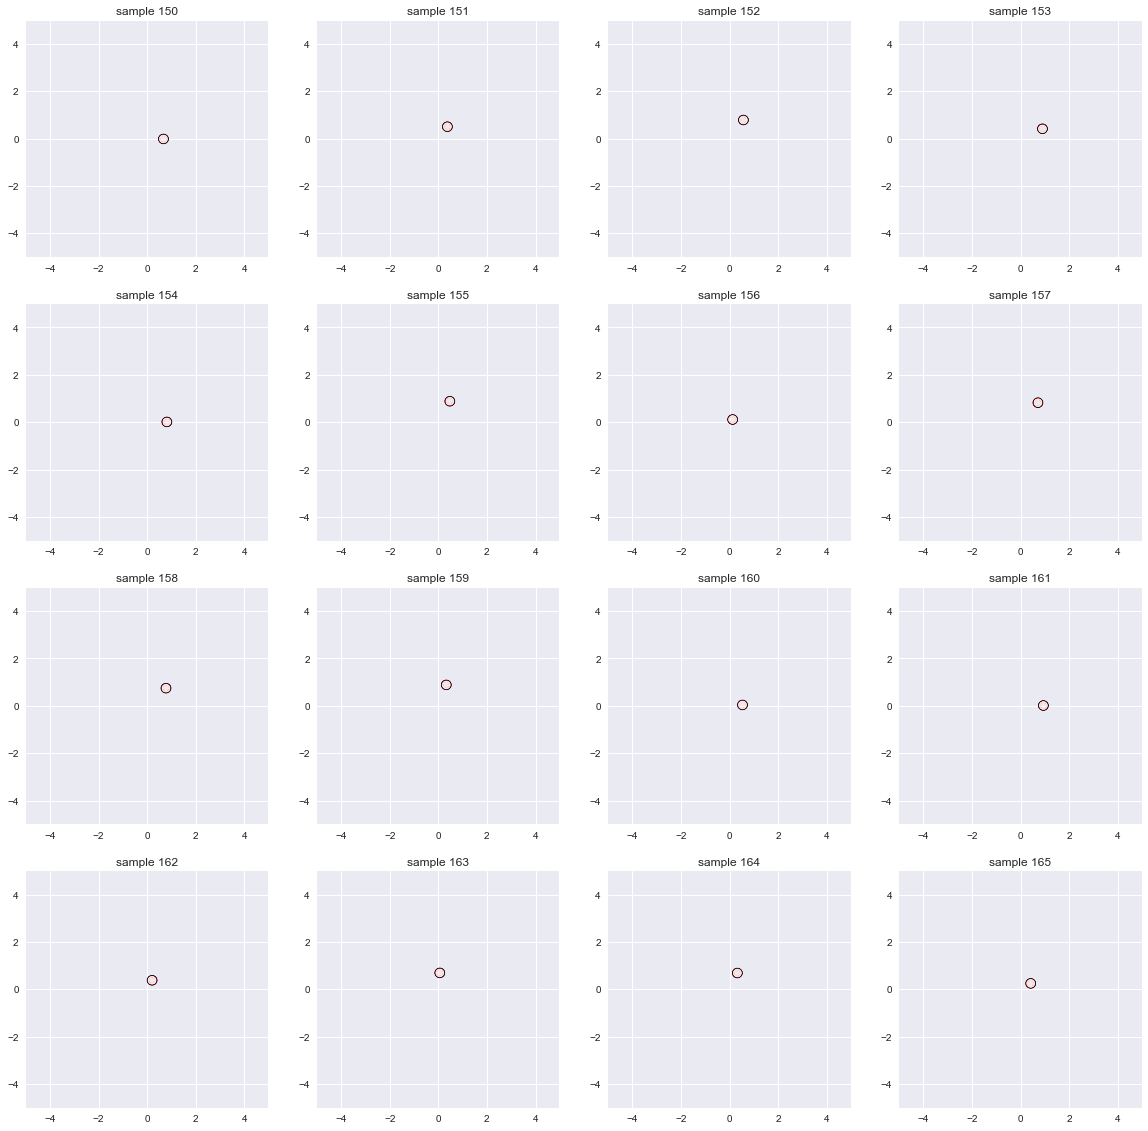

In [34]:
fig,ax=plt.subplots(4,4,figsize=(20,20))
for i in range(4):
    for j in range(4):
        plot_result(ax[i,j],150+i*4+j)

In [44]:
prediction_xy = np.ndarray([250,2])
probabes = np.ndarray([250])
for i in tqdm(range(250)):
    probabes[i], prediction_xy[i] = get_prediction(pi_reversed[i], mu_reversed[i],sigma_reversed[i])

HBox(children=(IntProgress(value=0, max=250), HTML(value=u'')))

In [36]:
prediction_xy_reverse = scalers[3].inverse_transform(prediction_xy)

In [37]:
def plot_arrow(y_testdata,y_test):
    fig,ax=plt.subplots(1,figsize=(9,9))
    c = np.sum(y_testdata**2+y_test**2,axis=1)
    ax.scatter(y_testdata[:,0],y_testdata[:,1], s=25, c=c, cmap=plt.cm.coolwarm, zorder=10)
    ax.scatter(y_test[:,0],y_test[:,1], s=25, c=c, cmap=plt.cm.coolwarm, zorder=10)
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  
        np.max([ax.get_xlim(), ax.get_ylim()]),  
    ]
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    xorigin = y_testdata[:,0].ravel()
    yorigin = y_testdata[:,1].ravel()
    dx = y_test[:,0].ravel()-y_testdata[:,0].ravel()
    dy = y_test[:,1].ravel()-y_testdata[:,1].ravel()
    print (xorigin.shape, yorigin.shape, dx.shape, dy.shape)
    ax.arrow(xorigin[2], yorigin[2], dx[2], dy[2], color = 'b')
    for i in range(y_testdata.shape[0]):
        ax.arrow(y_testdata[i,0],y_testdata[i,1],
            y_test[i,0]-y_testdata[i,0],y_test[i,1]-y_testdata[i,1],color = 'b')
#for i in range(y_testdata.shape[0]):
#    ax.arrow(y_testdata[i,0],y_testdata[i,1],
#            y_test[i,0]-y_testdata[i,0],y_test[i,1]-y_testdata[i,1],color = 'b')

In [41]:
def report_metrics(y_test_data,y_test):
    rmse = np.mean(np.sum((y_test_data - y_test)**2,axis=1)**0.5)
    pcc = scipy.stats.pearsonr(y_test_data.ravel(),y_test.ravel())
    return rmse,pcc
report_metrics(prediction_xy_reverse,y_test)

(492.72935721675634, (0.985659449330351, 0.0))

In [42]:
y_test.shape

(250, 2)

((250,), (250,), (250,), (250,))


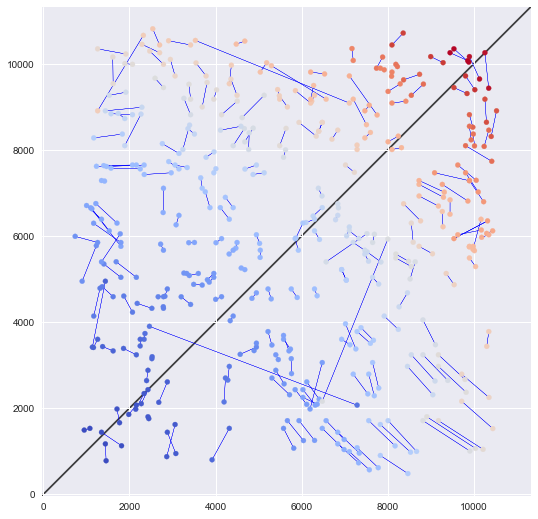

In [43]:
plot_arrow(prediction_xy_reverse,y_test)

In [45]:
probabes

array([6.42076822e+01, 6.42076837e+01, 6.42076874e+01, 6.42076807e+01,
       6.42076874e+01, 6.42076874e+01, 6.42076895e+01, 5.58013206e-10,
       6.10804204e+01, 6.42076874e+01, 6.42076286e+01, 6.42076802e+01,
       6.42076874e+01, 6.42076874e+01, 6.42076856e+01, 6.42076874e+01,
       6.42069181e+01, 6.42075462e+01, 6.42069589e+01, 6.42074565e+01,
       6.42075758e+01, 6.42024558e+01, 6.42076878e+01, 6.42076874e+01,
       6.42073468e+01, 6.42074744e+01, 6.42076874e+01, 6.42076874e+01,
       6.42076874e+01, 6.42076425e+01, 6.42076874e+01, 6.42073529e+01,
       6.42076875e+01, 6.42076874e+01, 6.42076874e+01, 6.42076874e+01,
       6.42076876e+01, 6.42075115e+01, 6.42074472e+01, 6.42076837e+01,
       6.42076874e+01, 6.42076874e+01, 6.42076874e+01, 6.42073656e+01,
       6.42076819e+01, 6.42076623e+01, 6.42076695e+01, 6.42076874e+01,
       6.42076674e+01, 6.42070520e+01, 6.42076874e+01, 6.42055213e+01,
       6.42076874e+01, 6.42076874e+01, 6.42076874e+01, 6.42076874e+01,
      

### 后续思路
- probablity 大于1且非常大
- 大规模测试参数： RMSE作为衡量指标
    - Gaussian数量
    - MLP网络相关参数
        - layer
        - activation...
- outlier：距离差大的是不是不确定度也大
    - 看看误差大的样本是不是不确定度也大，如果真的相关性强的话，那我们就找到了一个很好的方法来衡量样本的预测难度
- 借鉴bishop的一些绘图思路，可视化出来probablity
- 生成二维分布时是否可以考虑$\rho$
- 其他
- 与其他模型比较，可信度可以直接得知？